In [1]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import os

# enable R cells
%load_ext rpy2.ipython

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# requires apt-get install r-base
os.environ["R_HOME"]="/usr/lib/R/"

#### Load Database in R

export to rdf variable

In [2]:
%%R -o rdf
load("Databases/UCR-4.RData")
database[1]
rdf <- data.frame(database);

## Dataset inspection

inspect single examples in python

In [3]:
print(rdf.shape)
print(rdf.columns)

(930, 130)
Index(['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       ...
       'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'tt',
       'c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..'],
      dtype='object', length=130)


field `tt` seems to be the training or test split

In [4]:
print(np.sum(rdf["tt"]==0.0))
print(np.sum(rdf["tt"]==1.0))

30
900


In [5]:
print(pd.unique(rdf["tt"]))
print(pd.unique(rdf["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]))

[0. 1.]
[1. 3. 2.]


**findings/questions**:

the dataset `UCR-4.RData` seems to be `CBF` http://www.timeseriesclassification.com/description.php?Dataset=CBF

* values start from `V2` (where is `V1`?)
* field 'tt' seems to be the training (`0.0`) or test (`1.0`) split
* field `c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..` is likely the label `1` `2` `3`. **It has a a very strange name**, though.

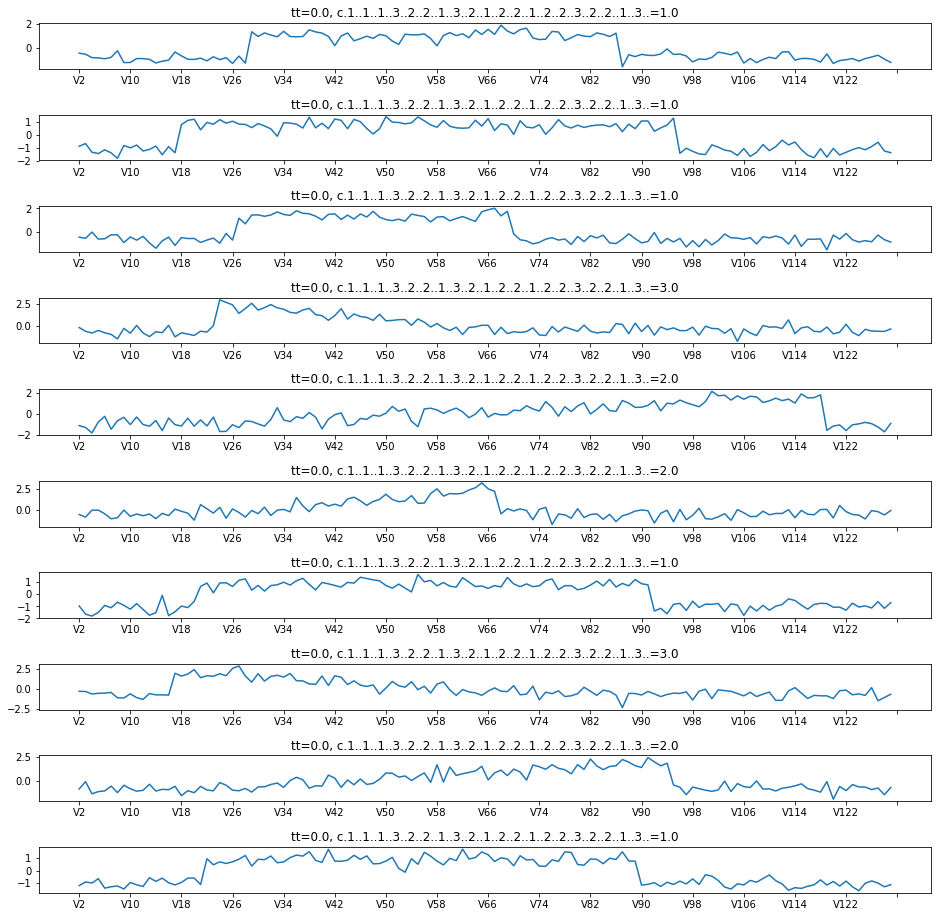

In [6]:
# take only V* columns
values = rdf.filter(regex="V")

n=10
fig,ax = plt.subplots(n,1,figsize=(16,16))
for i in range(n):
    ax[i].plot(values.iloc[i])
    
    tt=rdf.iloc[i]["tt"]
    c=rdf.iloc[i]["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]
    
    title="tt={}, c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..={}".format(tt,c)
    ax[i].set_title(title)
    
    # plot fewer ticks
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

## TODOs

* Load `BavarianCrops` dataset and bring it to the same format
* Save `BavarianCrops` dataset as in the Rdata format (as `UCR-4.RData` for simplicity?)
* run the training and predict script again